<a href="https://colab.research.google.com/github/jackkim-usd/AAI521-group4/blob/main/aai_521_final_project_jack_kim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow tensorflow-datasets scikit-learn

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# Load full TFDS split once
(ds_all, ds_info) = tfds.load(
    "plant_village",
    split="train",
    as_supervised=True,
    with_info=True
)

total = ds_info.splits["train"].num_examples
print("Total images:", total)

# Shutffle but same seed for everyone (seed=4 because we're group 4)
ds_all = ds_all.shuffle(10000, seed=4, reshuffle_each_iteration=False)

# Fixed subset sizes because our dataset is too large, causing our code to crash even on GPU
train_count = 4000
val_count   = 800
test_count  = 800

train_ds = ds_all.take(train_count)
rest_ds  = ds_all.skip(train_count)
val_ds   = rest_ds.take(val_count)
test_ds  = rest_ds.skip(val_count).take(test_count)

train_count, val_count, test_count

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.P7P8EB_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Total images: 54303


(4000, 800, 800)

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, img_size, batch_size, training):
    def _resize_normalize(image, label):
        image = tf.image.resize(image, (img_size, img_size))
        image = tf.cast(image, tf.float32)
        return image, label

    ds = ds.map(_resize_normalize, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.shuffle(1000)
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

In [ ]:
num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

In [ ]:
def build_efficientnet(model_name, img_size, num_classes):
    if model_name == "b0":
        base = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights="imagenet",
            input_shape=(img_size, img_size, 3),
        )
    elif model_name == "b3":
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            weights="imagenet",
            input_shape=(img_size, img_size, 3),
        )
    elif model_name == "b4":
        base = tf.keras.applications.EfficientNetB4(
            include_top=False,
            weights="imagenet",
            input_shape=(img_size, img_size, 3),
        )
    else:
        raise ValueError("model_name must be 'b0', 'b3', or 'b4'.")

    base.trainable = False

    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name=f"EfficientNet_{model_name}")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
def plot_history(history, title=""):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title(f"{title} accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(f"{title} loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def run_experiment(model_name, img_size, batch_size=32, epochs=8):
    print(f"\n=== EfficientNet{model_name.upper()} @ {img_size}x{img_size} ===")

    train_prep = prepare_dataset(train_ds, img_size, batch_size, training=True)
    val_prep   = prepare_dataset(val_ds,   img_size, batch_size, training=False)
    test_prep  = prepare_dataset(test_ds,  img_size, batch_size, training=False)

    model = build_efficientnet(model_name, img_size, num_classes)

    history = model.fit(
        train_prep,
        validation_data=val_prep,
        epochs=epochs,
    )

    plot_history(history, title=f"EfficientNet{model_name.upper()}")

    y_true = []
    y_pred = []

    for batch_images, batch_labels in test_prep:
        logits = model.predict(batch_images, verbose=0)
        preds = np.argmax(logits, axis=1)
        y_true.extend(batch_labels.numpy())
        y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")

    print(f"Test accuracy: {acc:.4f}")
    print(f"Macro F1 score: {f1:.4f}\n")

    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        fmt="d",
        annot=False,
    )
    plt.title(f"Confusion matrix – EfficientNet{model_name.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return model, history, acc, f1


=== EfficientNetB0 @ 224x224 ===
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 131ms/step - accuracy: 0.0653 - loss: 3.6118 - val_accuracy: 0.1912 - val_loss: 3.0050
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.2455 - loss: 2.9298 - val_accuracy: 0.4288 - val_loss: 2.5338
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.3880 - loss: 2.5254 - val_accuracy: 0.5213 - val_loss: 2.1869
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.4910 - loss: 2.1910 - val_accuracy: 0.5950 - val_loss: 1.9211
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5532 - loss: 1.9542 - val_accuracy: 0.6500 - val_loss: 1.7125


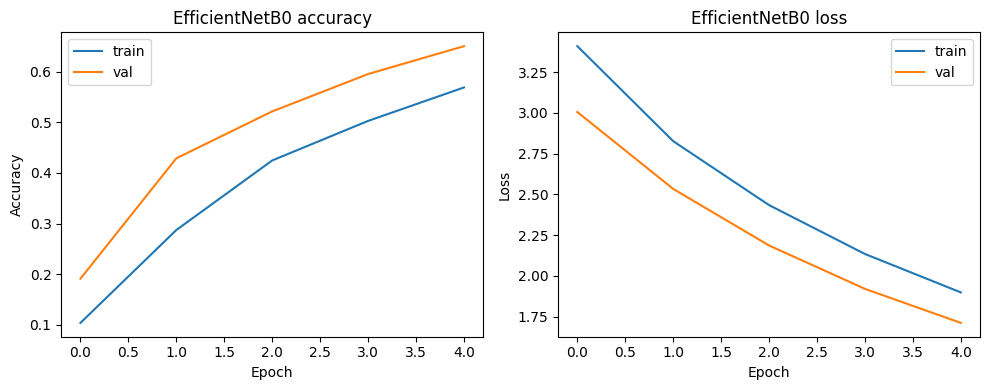

Test accuracy: 0.6350
Macro F1 score: 0.4262

Classification report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.00      0.00      0.00        10
                            Apple___Black_rot       1.00      0.42      0.59        12
                     Apple___Cedar_apple_rust       0.00      0.00      0.00         3
                              Apple___healthy       0.53      0.53      0.53        17
                          Blueberry___healthy       0.92      0.61      0.73        18
                             Cherry___healthy       0.00      0.00      0.00        12
                      Cherry___Powdery_mildew       1.00      0.15      0.26        20
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        10
                           Corn___Common_rust       0.71      1.00      0.83        17
                               Corn___healthy       1.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


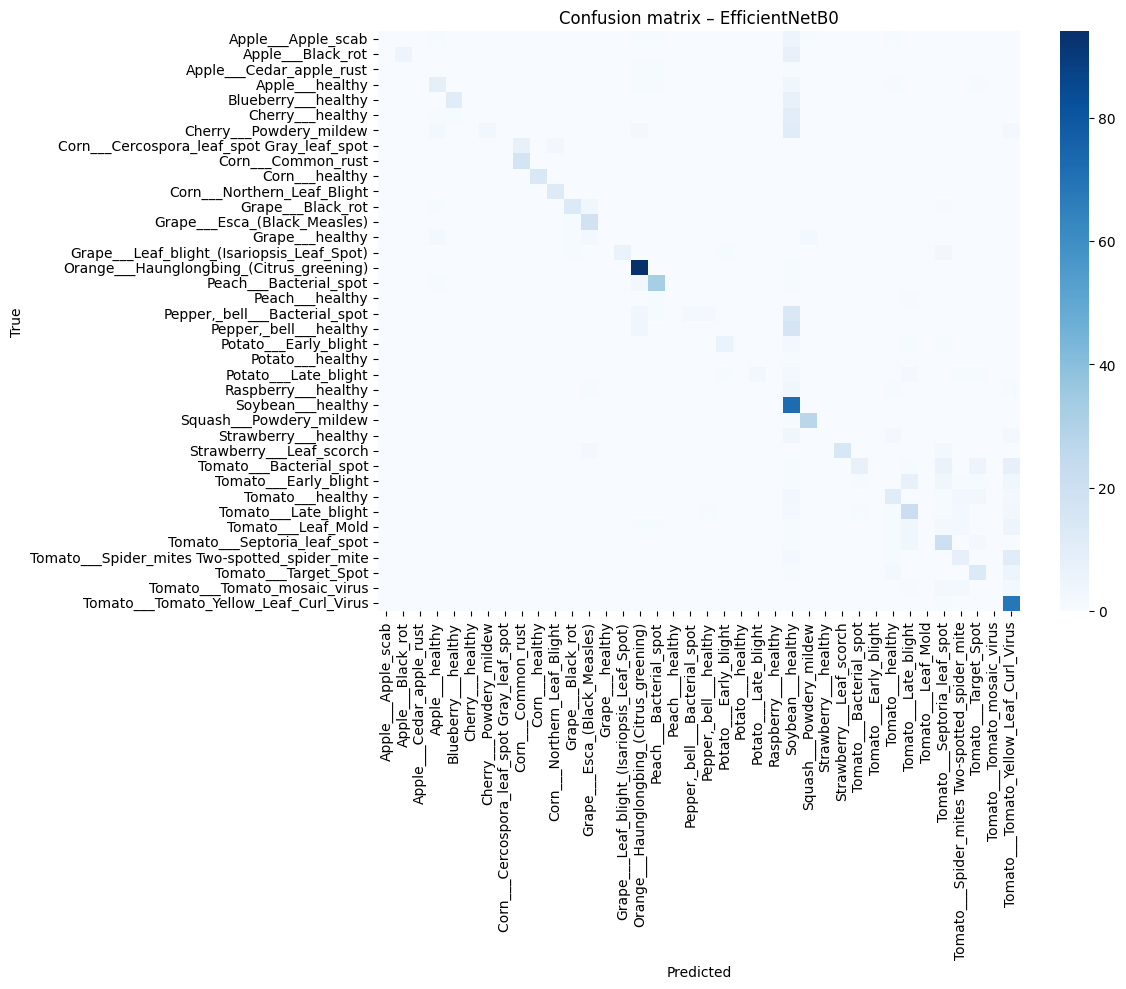

In [ ]:
# EfficientNetB0
model_b0, hist_b0, acc_b0, f1_b0 = run_experiment(
    model_name="b0",
    img_size=224,
    batch_size=32,
    epochs=5,
)

In [ ]:
print("EfficientNetB0 results:")
print(f"Accuracy: {acc_b0:.4f}")
print(f"Macro F1: {f1_b0:.4f}")

EfficientNetB0 results:
Accuracy: 0.6350
Macro F1: 0.4262



=== EfficientNetB3 @ 300x300 ===
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 107ms/step - accuracy: 0.1554 - loss: 3.3609 - val_accuracy: 0.3688 - val_loss: 2.6263
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.3737 - loss: 2.5578 - val_accuracy: 0.5100 - val_loss: 2.1159
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.5156 - loss: 2.0675 - val_accuracy: 0.6000 - val_loss: 1.7722
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.6149 - loss: 1.7415 - val_accuracy: 0.6687 - val_loss: 1.5230
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.6732 - loss: 1.5369 - val_accuracy: 0.7250 - val_loss: 1.3361


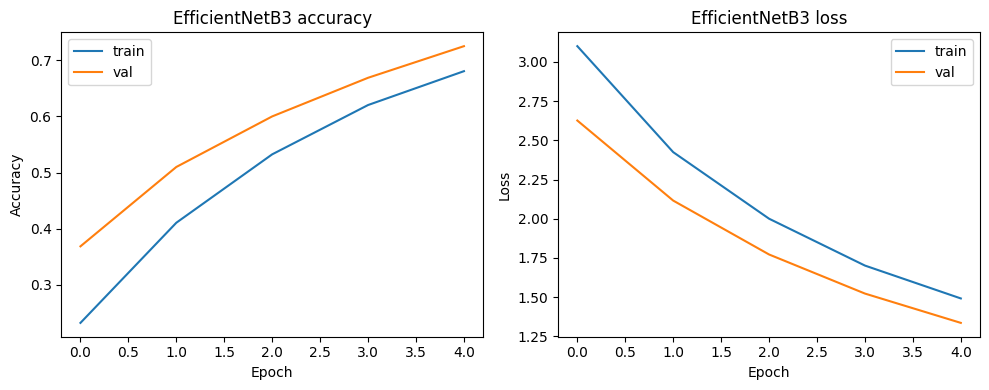

Test accuracy: 0.7362
Macro F1 score: 0.5616

Classification report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.10      0.18        10
                            Apple___Black_rot       0.83      0.42      0.56        12
                     Apple___Cedar_apple_rust       0.00      0.00      0.00         3
                              Apple___healthy       0.58      0.65      0.61        17
                          Blueberry___healthy       0.78      1.00      0.88        18
                             Cherry___healthy       0.82      0.75      0.78        12
                      Cherry___Powdery_mildew       0.86      0.30      0.44        20
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        10
                           Corn___Common_rust       0.94      0.94      0.94        17
                               Corn___healthy       1.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


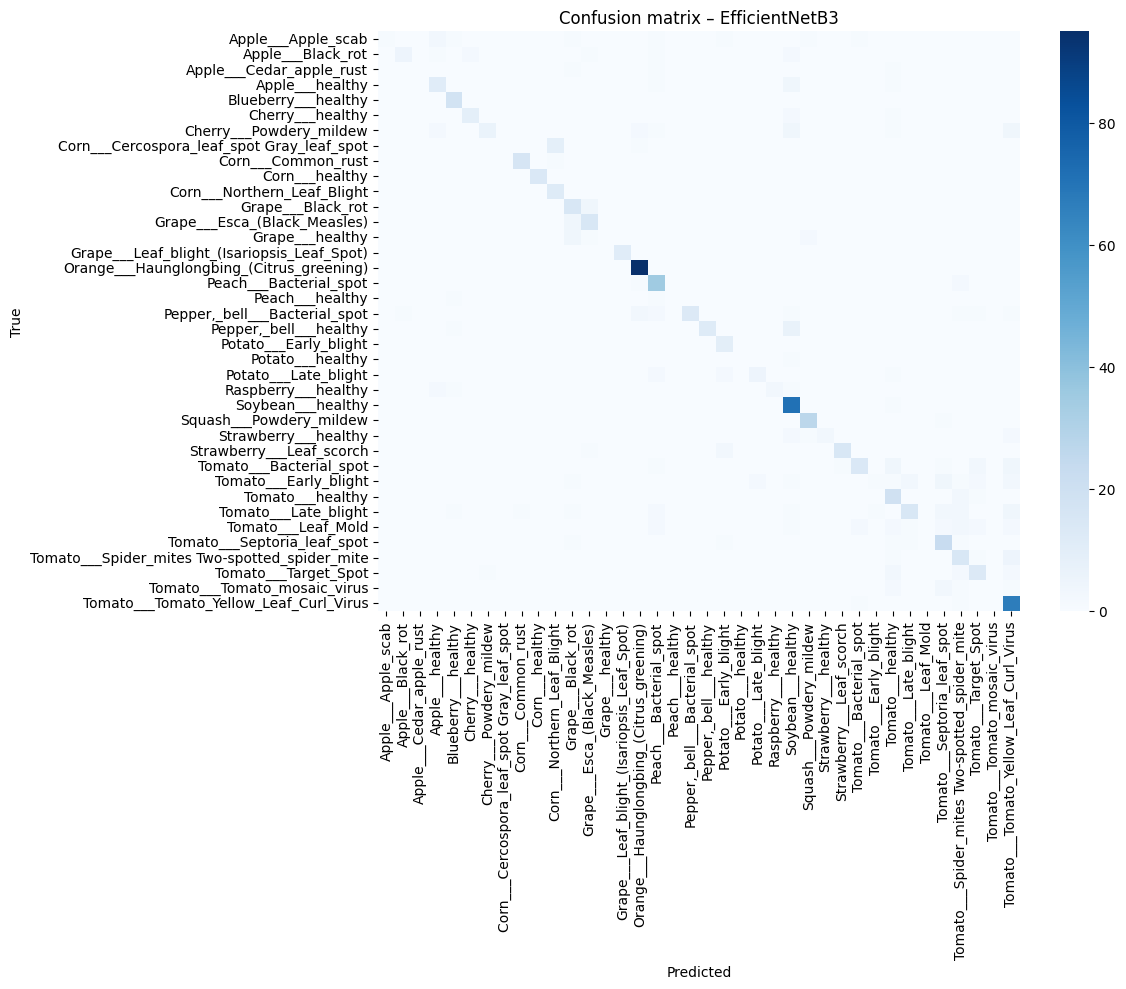

In [ ]:
# EfficientNetB3
model_b3, hist_b3, acc_b3, f1_b3 = run_experiment(
    model_name="b3",
    img_size=300,
    batch_size=16,
    epochs=5,
)

In [ ]:
print("EfficientNetB3 results:")
print(f"Accuracy: {acc_b3:.4f}")
print(f"Macro F1: {f1_b3:.4f}")

EfficientNetB3 results:
Accuracy: 0.7362
Macro F1: 0.5616



=== EfficientNetB4 @ 300x300 ===
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.1705 - loss: 3.2688 - val_accuracy: 0.4387 - val_loss: 2.3631
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.4510 - loss: 2.2674 - val_accuracy: 0.5938 - val_loss: 1.7920
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.5990 - loss: 1.7585 - val_accuracy: 0.6900 - val_loss: 1.4573
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.6806 - loss: 1.4790 - val_accuracy: 0.7325 - val_loss: 1.2345
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.7402 - loss: 1.2398 - val_accuracy: 0.7875 - val_loss: 1.0756


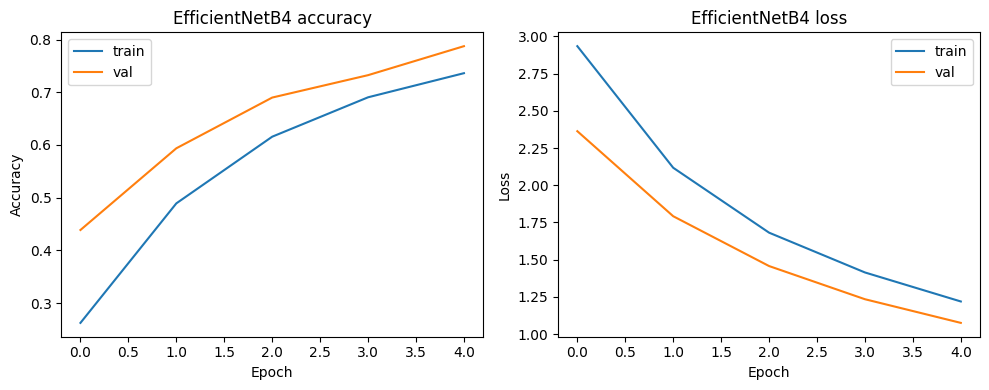

Test accuracy: 0.7875
Macro F1 score: 0.6705

Classification report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.20      0.33        10
                            Apple___Black_rot       1.00      0.92      0.96        12
                     Apple___Cedar_apple_rust       1.00      0.33      0.50         3
                              Apple___healthy       0.68      0.76      0.72        17
                          Blueberry___healthy       0.69      1.00      0.82        18
                             Cherry___healthy       1.00      0.92      0.96        12
                      Cherry___Powdery_mildew       1.00      0.05      0.10        20
   Corn___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.20      0.33        10
                           Corn___Common_rust       1.00      1.00      1.00        17
                               Corn___healthy       0.93    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


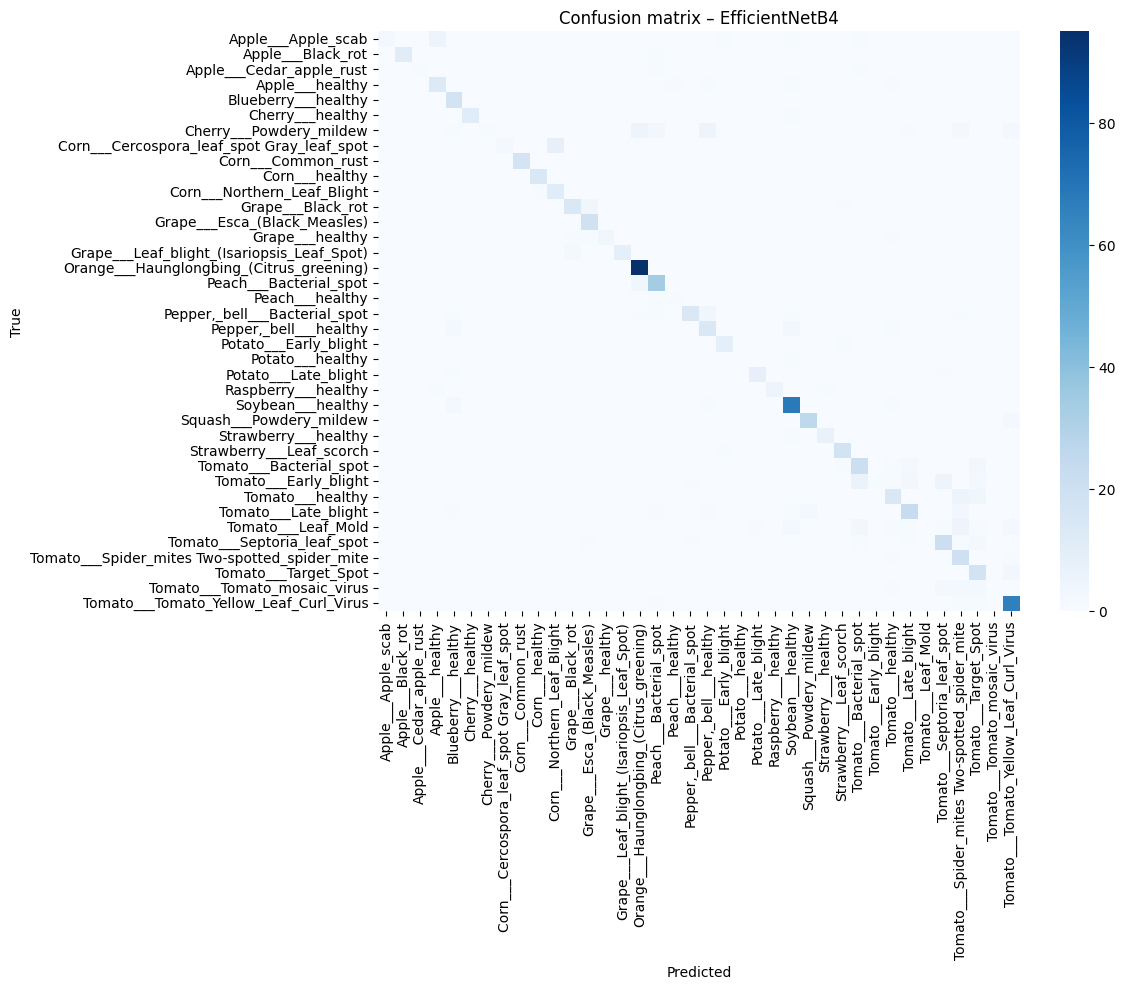

In [ ]:
# EfficientNetB4
model_b4, hist_b4, acc_b4, f1_b4 = run_experiment(
    model_name="b4",
    img_size=300, #ideally 380 but reduced to save it from crashing
    batch_size=8,
    epochs=5,
)

In [ ]:
print("EfficientNetB4 results:")
print(f"Accuracy: {acc_b4:.4f}")
print(f"Macro F1: {f1_b4:.4f}")

EfficientNetB4 results:
Accuracy: 0.7875
Macro F1: 0.6705
